In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skewnorm, skew, norm, shapiro

In [2]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

In [3]:
def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [4]:
X = gen_skewnormal(5, 2, 4, 100000, 42)
X.var()

2.004927890730308

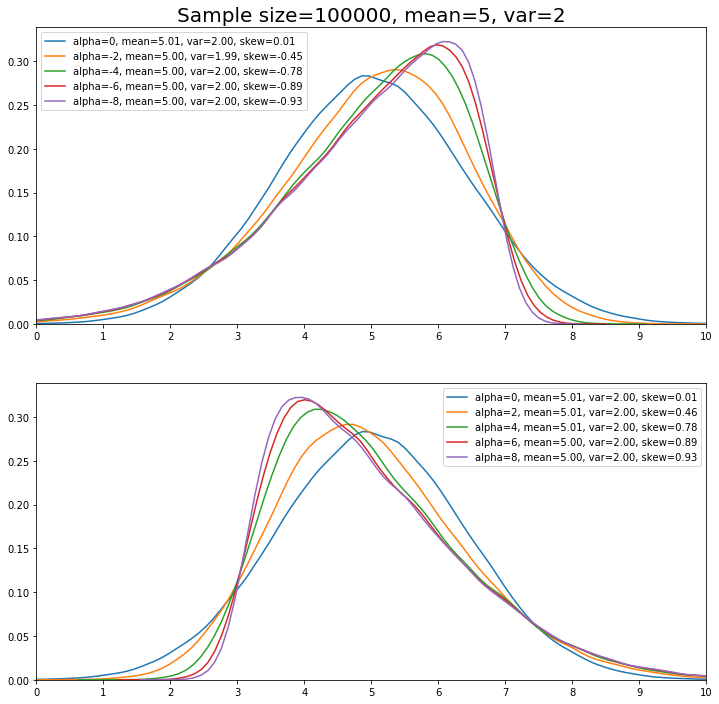

In [5]:
size = 100000
mean = 5
var = 2

fig, axs = plt.subplots(figsize=(12, 12), nrows=2)
for alpha in np.arange(0, 10, 2):
    alpha *= -1
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[0])

for alpha in np.arange(0, 10, 2):
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[1])
    
title = f'Sample size={size}, mean={mean}, var={var}'
axs[0].set_title(title, fontsize=20)
axs[0].set_xlim([mean-5, mean+5])
axs[0].set_xticks([i for i in range(0, 11)])
axs[1].set_xlim([mean-5, mean+5])
axs[1].set_xticks([i for i in range(0, 11)]);

### Find the experiment alpha values

In [6]:
### find a random seed that the skewness of generated X is close to theory value

alphas = np.arange(0.15, 1.65, 0.3)

size = 4500
for alpha in alphas:
    for _ in range(100):
        rseed = np.random.randint(0, 200)
        X = gen_skewnormal(0, 2, alpha, size, rseed)
        if alpha == 0:
            if np.abs(skew(X)) <= 0.01:
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
        else:
            if np.abs(skew(X) - tskew(alpha)) <= 0.1 * tskew(alpha):
                print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}')
                break
    else:
        print(f'alpha = {alpha:.2f}, rseed = {rseed:3d}, tskew = {tskew(alpha):.3f}, skew = {skew(X):6.3f}'
              + '  FAIL to find the best rseed.')

alpha = 0.15, rseed = 112, tskew = 0.001, skew = -0.094  FAIL to find the best rseed.
alpha = 0.45, rseed =  80, tskew = 0.018, skew =  0.017
alpha = 0.75, rseed = 163, tskew = 0.070, skew =  0.063
alpha = 1.05, rseed =  89, tskew = 0.152, skew =  0.137
alpha = 1.35, rseed = 175, tskew = 0.250, skew =  0.256


,mean,var,tskew,skew,W,p-value
0.15,0.000881,1.934791,0.001,0.033,1.000,0.66832
0.45,-0.007957,1.930086,0.018,0.018,1.000,0.73021
0.75,-0.028184,1.961639,0.070,0.075,0.999,0.05804
1.05,0.013837,1.931826,0.152,0.161,0.998,0.00006
1.35,-0.004664,1.996977,0.250,0.226,0.997,0.00000


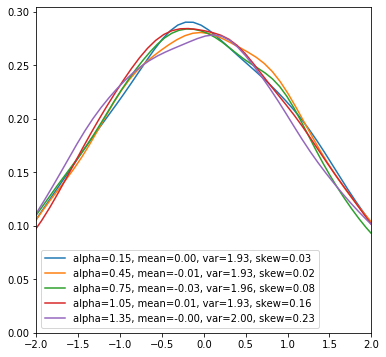

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

result = {}
rseeds = [58, 97, 0, 124, 132]
for rseed, alpha in zip(rseeds, alphas):
    X = gen_skewnormal(0, 2, alpha, size, rseed)
    W, p = shapiro(X)
    result[alpha] = [X.mean(), X.var(), tskew(alpha), skew(X), W, p]
    label = f'alpha={alpha:.2f}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}'
    sns.kdeplot(X, label=label, ax=ax)
    
ax.set_xlim([-2, 2])

df = pd.DataFrame(result, index=['mean', 'var', 'tskew', 'skew', 'W', 'p-value']).T
df.index.name = 'alpha'

df_s = df.copy()
df_s.index = [f'{idx:.2f}' for idx in df_s.index]
df_s['tskew'] = df_s['tskew'].map(lambda y: f'{y:.3f}')
df_s['skew'] = df_s['skew'].map(lambda y: f'{y:.3f}')
df_s['W'] = df_s['W'].map(lambda y: f'{y:.3f}')
df_s['p-value'] = df_s['p-value'].map(lambda y: f'{y:.5f}')
df_s

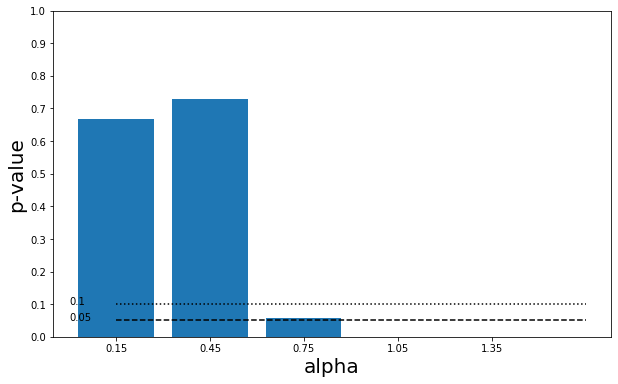

In [8]:
plt.figure(figsize=(10, 6))
x = df_s.index.values
p = df['p-value'].values
plt.bar(x, p)

plt.hlines(0.1, 0, len(alphas), ls='dotted')
plt.hlines(0.05, 0, len(alphas), ls='dashed')
plt.text(-0.5, 0.1, '0.1')
plt.text(-0.5, 0.05, '0.05')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('alpha', fontsize=20)
plt.ylabel('p-value', fontsize=20);

### 測試 skewnorm 的 sampling error。看樣本數要多少，用正負alpha各自計算出來的偏度才會同值異號

In [9]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

size = 50
alpha = 0.4:   skew=0.5366494455931908
alpha = -0.4:  skew=-0.3060083491364489
size = 100
alpha = 0.4:   skew=-0.19492162552412534
alpha = -0.4:  skew=-0.30955774351038734
size = 1000
alpha = 0.4:   skew=0.04713015611019288
alpha = -0.4:  skew=0.004943883117823934
size = 10000
alpha = 0.4:   skew=-0.008115700539673245
alpha = -0.4:  skew=-0.018675715904466542
size = 100000
alpha = 0.4:   skew=0.016284387042956726
alpha = -0.4:  skew=-0.012623095397719282
size = 1000000
alpha = 0.4:   skew=0.014124589327585653
alpha = -0.4:  skew=-0.010775132834420333
size = 2000000
alpha = 0.4:   skew=0.015353472941194296
alpha = -0.4:  skew=-0.013711753976170913
size = 5000000
alpha = 0.4:   skew=0.013246660530985017
alpha = -0.4:  skew=-0.0131514572875887


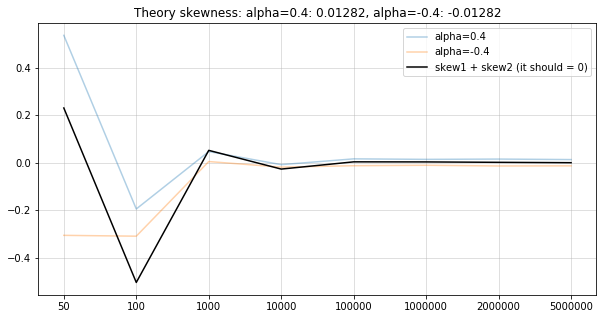

In [10]:
### alpha = 0.4 or -0.4

alpha = 0.4
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度，似乎要到萬等級的樣本數，偏度值才會比較穩定
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

size = 50
alpha = 2.5:   skew=0.8716714171772687
alpha = -2.5:  skew=-0.7069937305211653
size = 100
alpha = 2.5:   skew=0.12878944627301592
alpha = -2.5:  skew=-0.6328211021623613
size = 1000
alpha = 2.5:   skew=0.5922529797443279
alpha = -2.5:  skew=-0.40361756545525906
size = 10000
alpha = 2.5:   skew=0.5569036493316236
alpha = -2.5:  skew=-0.5607080336867291
size = 100000
alpha = 2.5:   skew=0.5964894265605386
alpha = -2.5:  skew=-0.5665402727729336
size = 1000000
alpha = 2.5:   skew=0.5777384715576014
alpha = -2.5:  skew=-0.5743065619263648
size = 2000000
alpha = 2.5:   skew=0.5791558984030785
alpha = -2.5:  skew=-0.5746548807973084
size = 5000000
alpha = 2.5:   skew=0.5763111749518454
alpha = -2.5:  skew=-0.575103292983566


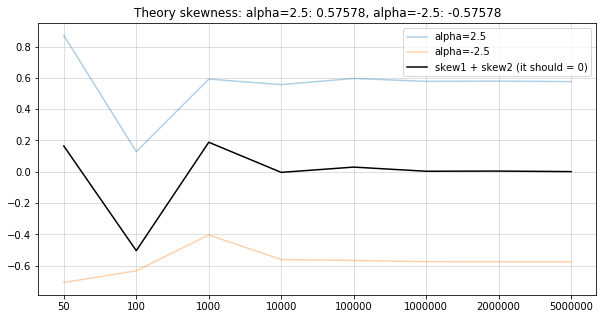

In [11]:
### alpha = 2.5 or -2.5

alpha = 2.5
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

# 似乎alpha大時，算出來的樣本偏度比alpha小時還要更快收斂

### kurtosis

In [12]:
def sinh_arcsinh_transform(x, epsilon, delta):
    return np.sinh(delta*np.arcsinh(x)-epsilon) * delta * np.cosh(delta*np.arcsinh(x)-epsilon) / np.sqrt(1+x**2)

(array([ 4.,  1.,  8., 14., 21., 19., 15.,  7.,  4.,  7.]),
 array([-2.3809011 , -1.93426534, -1.48762958, -1.04099382, -0.59435806,
        -0.1477223 ,  0.29891346,  0.74554922,  1.19218497,  1.63882073,
         2.08545649]),
 <a list of 10 Patch objects>)

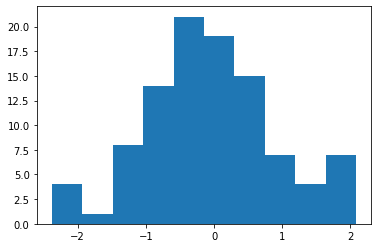

In [67]:
x = np.random.normal(loc=0, scale=1, size=100)
plt.hist(x)

(array([ 3.,  1.,  5.,  9., 25., 25., 18.,  4.,  4.,  6.]),
 array([-5.42934863, -4.43299194, -3.43663525, -2.44027856, -1.44392187,
        -0.44756518,  0.54879151,  1.5451482 ,  2.54150489,  3.53786158,
         4.53421827]),
 <a list of 10 Patch objects>)

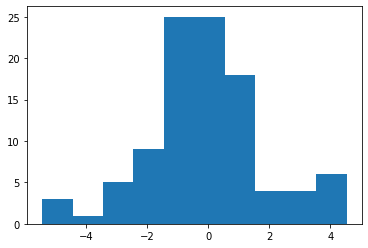

In [68]:
plt.hist(sinh_arcsinh_transform(x, 0, 1.2))

In [140]:
from scipy.special import kv

def P(q):
    return np.exp(1)**0.25 * (kv(q/2+0.5, 0.25) + kv(q/2-0.5, 0.25)) / np.sqrt(8*np.pi)

def moments(epsilon, delta):
    m1 = np.sinh(epsilon/delta) * P(1/delta)
    m2 = 0.5 * np.cosh(2*epsilon/delta) * P(2/delta) - 0.5
    m3 = 0.25 * (np.sinh(3*epsilon/delta) * P(3/delta) - 3 * np.sinh(epsilon/delta) * P(1/delta))
    m4 = 0.125 * (np.cosh(4*epsilon/delta) * P(4/delta) - 4 * np.cosh(2*epsilon/delta) * P(2/delta) + 3)
    return (m1, m2, m3, m4)

In [151]:
from scipy.stats import kurtosis, skew

m1, m2, m3, m4 = moments(0, 1.2)
v = m2 - m1**2
print(m4/v**2)

ss = []
for i in range(1000):
    x = np.random.normal(loc=0, scale=1, size=200)
    s = sinh_arcsinh_transform(x, 0, 1.2)
    ss.append(kurtosis(s))
print(np.mean(ss))

2.691765099855022
1.4068020941052688


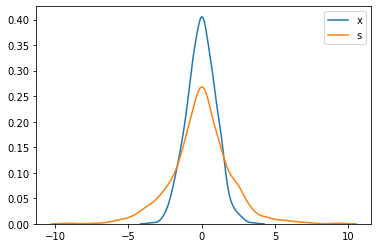

In [162]:
x = np.random.normal(loc=0, scale=1, size=2000)
s = sinh_arcsinh_transform(x, 0, 1.2)

fig, ax = plt.subplots()
sns.kdeplot(x, label='x', ax=ax)
sns.kdeplot(s, label='s', ax=ax)

In [161]:
from scipy.stats import kurtosis, skew

def simu_mvsk(loc, scale, epsilon, delta):
    hmean = []
    hvar = []
    hskew = []
    hkurt = []
    for i in range(1000):
        x = np.random.normal(loc=loc, scale=scale, size=2000)
        s = sinh_arcsinh_transform(x, epsilon, delta)
        hmean.append(s.mean())
        hvar.append(s.var())
        hskew.append(skew(s))
        hkurt.append(kurtosis(s))

    return np.mean(hmean), np.mean(hvar), np.mean(hskew), np.mean(hkurt) 
    
simu_mvsk(0, 1, 0, 1.2)

(9.638413709562502e-05,
 3.956481732755864,
 0.001988805638975305,
 1.6136169574578887)

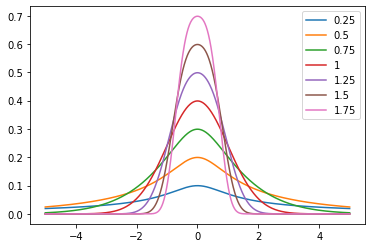

In [181]:
from scipy.stats import rv_continuous

class sinh_arcsinh(rv_continuous):
    epsilon = 0
    delta = 1
    
    def _pdf(self, x):
        epsilon = self.epsilon
        delta = self.delta
        
        p1 = 1/np.sqrt(2*np.pi) * np.exp(np.sinh(delta*np.arcsinh(x)-epsilon)**2 / -2) 
        p2 = np.cosh(delta * np.arcsinh(x) - epsilon) * delta / np.sqrt(1+x**2)
        return p1 * p2


my_cv = sinh_arcsinh()
my_cv.epsilon

x = np.linspace(-5, 5, 1000)
for e in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]:
    my_cv.delta = e
    plt.plot(x, my_cv.pdf(x), label=str(e))
plt.legend(loc='upper right')

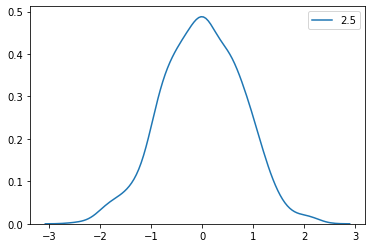

In [224]:
fig, ax = plt.subplots()

my_cv.delta = 1.2
samples = my_cv.rvs(size=1000)
sns.kdeplot(samples, label=str(e), ax=ax)

In [236]:
my_cv.epsilon = 0
my_cv.delta = 1
my_cv.var(scale=np.sqrt(2))

1.9999999986137917